In [1]:
import pandas as pd
import numpy as np
import os
# os.environ['TF_XLA_FLAGS'] = '--tf_xla_disable_xla_devices' # to run tensorflow on Mac M1 Pro (only one time)
import tensorflow as tf
import matplotlib.pyplot as plt
import sys

print(f"         Python: {sys.version} \n \
        TensorFlow: {tf.__version__} \n \
        Num GPUs Available: {len(tf.config.experimental.list_physical_devices('GPU'))}")

         Python: 3.10.9 | packaged by conda-forge | (main, Feb  2 2023, 20:26:08) [Clang 14.0.6 ] 
         TensorFlow: 2.11.0 
         Num GPUs Available: 1


# 1. Input Image and Score

In [2]:
# Images = X

from tensorflow.keras.utils import image_dataset_from_directory

# ID and Scores = index key and Y
df_train = pd.read_csv("df_train.csv", header='infer', sep=",")
df_vali = pd.read_csv("df_vali.csv", sep=",")
df_test = pd.read_csv("df_test.csv", sep=",")

In [12]:
df_test.head()

,ImageID,Score
0,476122,3.425926
1,528536,6.320755
2,899152,5.625000
3,677883,5.602740
4,570309,6.350877


In [13]:
from PIL import Image
import os

# Resizing
# since tensorflow 2.11 does not support 'target_size' parameter in ImageDataGenerator
# The images should be resized manually

# Define directory containing images
train_image_dir = "/Users/user/Desktop/Projects/CMSE890 - AML/image/train"
vali_image_dir = "/Users/user/Desktop/Projects/CMSE890 - AML/image/validation"
test_image_dir = "/Users/user/Desktop/Projects/CMSE890 - AML/image/test"
TARGET_SIZE = (299, 299)

def resize(directory):
    if not os.path.exists(directory):
        os.makedirs(train_image_dir)

    for filename in os.listdir(directory):
        if filename.endswith(".jpg"):
            # Open the image
            image = Image.open(os.path.join(directory, filename))

            # Resize the image
            image = image.resize(TARGET_SIZE)

            # Save the resized image
            output_path = os.path.join(directory, filename)
            image.save(output_path)

In [3]:
#resize(vali_image_dir)
#resize(test_image_dir)

In [115]:
# Define target image size and batch size
TARGET_SIZE = (299, 299)
BATCH_SIZE = 32

# Load dataframe containing ImageID and Score
df_train = pd.read_csv("df_train.csv", header='infer', sep = ",")
df_vali = pd.read_csv("df_vali.csv", sep = ",")
df_test = pd.read_csv("df_test.csv", sep = ",")

# Convert the ImageID column as string
df_train['ImageID'] = df_train['ImageID'].astype(str)
df_vali['ImageID'] = df_vali['ImageID'].astype(str)
df_test['ImageID'] = df_test['ImageID'].astype(str)

# Convert the Score column as float
df_train['Score'] = df_train['Score'].astype(float)
df_vali['Score'] = df_vali['Score'].astype(float)
df_test['Score'] = df_test['Score'].astype(float)

# Sorting the dataframe with ImageID
df_train = df_train.sort_values(by='ImageID')
df_vali = df_vali.sort_values(by='ImageID')
df_test = df_test.sort_values(by='ImageID')

df_train['ImageID_JPG'] = df_train['ImageID'].apply(lambda x: str(x) + '.jpg')
df_vali['ImageID_JPG'] = df_vali['ImageID'].apply(lambda x: str(x) + '.jpg')
df_test['ImageID_JPG'] = df_test['ImageID'].apply(lambda x: str(x) + '.jpg')

In [124]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define directory containing images
train_image_dir = "/Users/user/Desktop/Projects/CMSE890 - AML/image/train"
vali_image_dir = "/Users/user/Desktop/Projects/CMSE890 - AML/image/validation"
test_image_dir = "/Users/user/Desktop/Projects/CMSE890 - AML/image/test"

# Create an ImageDataGenerator object with rescaling
datagen = ImageDataGenerator(rescale=1./255)

# Create a flow_from_dataframe generator
# Training Data
train_generator = datagen.flow_from_dataframe(
    dataframe = df_train,
    directory = train_image_dir,
    x_col = "ImageID_JPG",
    y_col = "Score",
    target_size = TARGET_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = "raw", # other
    data_format='channels_last',
    shuffle = False
)

# Validation Data
vali_generator = datagen.flow_from_dataframe(
    dataframe = df_vali,
    directory = vali_image_dir,
    x_col = "ImageID_JPG",
    y_col = "Score",
    target_size = TARGET_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = "raw", # other
    data_format='channels_last',
    shuffle = False
)

# Testing Data
test_generator = datagen.flow_from_dataframe(
    dataframe = df_test,
    directory = test_image_dir,
    x_col = "ImageID_JPG",
    y_col = "Score",
    target_size = TARGET_SIZE,
    batch_size = 1,
    class_mode = None,
    data_format='channels_last',
    shuffle = False
)

Found 2496 validated image filenames.
Found 1246 validated image filenames.
Found 1247 validated image filenames.


In [125]:
import matplotlib.pyplot as plt
import numpy as np

def visualize(generator):
    # Check image and label
    images, labels = next(generator) 
    print(f" Image: {images.shape} \n Label: {labels.shape}")

    # Visualize the image data
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(6,6))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.set_title(f"Score: {labels[i]:.2f}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

 Image: (32, 299, 299, 3) 
 Label: (32,)


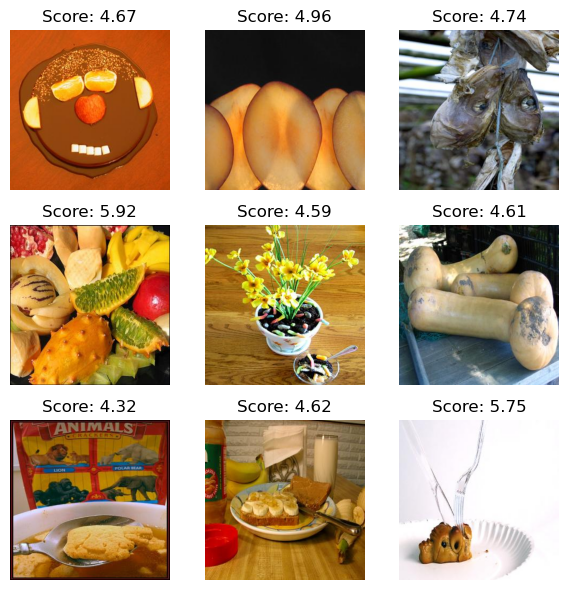

 Image: (32, 299, 299, 3) 
 Label: (32,)


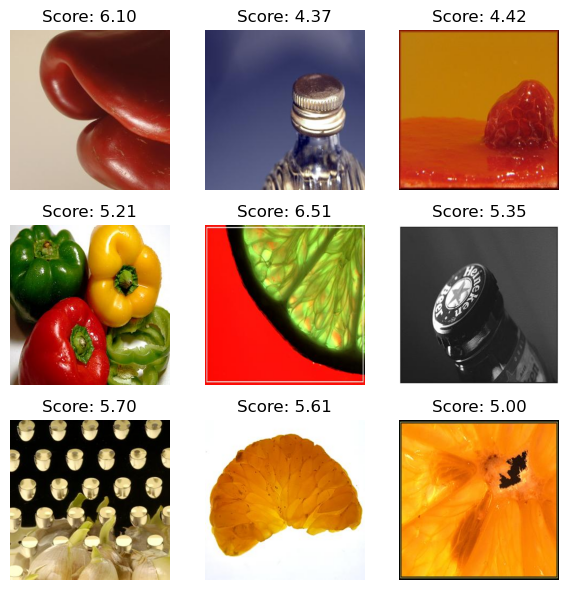

In [102]:
visualize(train_generator)
visualize(vali_generator)

# 3. Model Training

In [129]:
#X_train, y_train = next(train_generator)
#X_vali, y_vali = next(vali_generator)
X_test = next(test_generator)

#X_train = X_train.astype('float32')
#X_vali = X_vali.astype('float32')
#X_test = X_test.astype('float32')

#print(f" X_train: {X_train.shape} \n X_vali: {X_vali.shape} \n X_test: {X_test.shape}")
#print(f" y_train: {y_train.shape} \n y_vali: {y_vali.shape} \n y_test: {y_test.shape}")
print(f" X_test: {X_test.shape}")

 X_test: (1, 299, 299, 3)


    *Problem 1. When assign BATCH_SIZE(32 or 64) in generator, the training/validation/testing dataset size == BATCH_SIZE --> too small
    *Problem 2. Predictions (Aesthetic Score) are only one value. 

In [130]:
# Baseline model

from tensorflow.keras.applications.xception import Xception
from keras import Sequential, Model
from tensorflow.keras.optimizers.legacy import Adam # legacy -> get Tensorflow working on M1 Pro Chip
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Conv2D, BatchNormalization, Activation, Dropout


input_shape = (299,299,3)
base = Xception(weights="imagenet", include_top=False, input_shape=input_shape, pooling='avg')

# Freeze the layers so that they are not updated
for layer in base.layers:
    layer.trainable = False

    
#x = base.get_layer(index=len(base.layers)-2).output
#x = base.get_layer(index=len(base.layers)-2).output
#x = Dense(128, activation='relu')(x)
#x = Dense(64, activation='relu')(x)
#x = Dense(1, activation='linear')(x)
#model = Model(inputs=base.input, outputs=x)

# Add new layers
model = Sequential()
model.add(base)
model.add(Dense(64, activation='relu')) # Rectified Linear Unit
model.add(Dense(32, activation='relu')) # not activate all the neurons at the same time
model.add(Dense(1, activation='linear'))

#model = Sequential([
#    Flatten(input_shape=input_shape), # Flatten -> converts the multi-dimensional arrays into one-dimensional arrays
#    Dense(128, activation="relu"), # Rectified Linear Unit -> does not activate all the neurons at the same time
#    Dense(10), # Dense -> deeply connected to every neuron of its preceding layer
#    Dense(1)
#])


# Compile the model with the Adam optimizer
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error', metrics=['mean_absolute_error'])

In [131]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense_6 (Dense)             (None, 64)                131136    
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 20,994,729
Trainable params: 133,249
Non-trainable params: 20,861,480
_________________________________________________________________


In [132]:
# Callback to save the best model and Early Stopping to stop early if the validation loss stops improving
#import os
#os.environ['TF_XLA_FLAGS'] = '--tf_xla_disable_xla_devices'
import tensorflow as tf

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint('xception_best.h5', save_best_only=True, save_weights_only=True,
                             monitor='val_loss', mode='min', verbose=1)

earlystop = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)

history1 = model.fit(train_generator, steps_per_epoch=train_generator.n//train_generator.batch_size, epochs=50, 
                   validation_data=vali_generator, validation_steps=vali_generator.n//vali_generator.batch_size,
                   callbacks=[checkpoint, earlystop])

Epoch 1/50


2023-04-15 16:29:55.772298: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


78/78 [==============================] - ETA: 0s - loss: 2.4656 - mean_absolute_error: 1.1370

2023-04-15 16:30:24.715295: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 1.18805, saving model to xceptiion_best.h5
78/78 [==============================] - 44s 548ms/step - loss: 2.4656 - mean_absolute_error: 1.1370 - val_loss: 1.1880 - val_mean_absolute_error: 0.8722
Epoch 2/50
78/78 [==============================] - ETA: 0s - loss: 0.9662 - mean_absolute_error: 0.7802
Epoch 2: val_loss improved from 1.18805 to 0.98492, saving model to xceptiion_best.h5
78/78 [==============================] - 42s 536ms/step - loss: 0.9662 - mean_absolute_error: 0.7802 - val_loss: 0.9849 - val_mean_absolute_error: 0.7819
Epoch 3/50
78/78 [==============================] - ETA: 0s - loss: 0.7160 - mean_absolute_error: 0.6695
Epoch 3: val_loss improved from 0.98492 to 0.85818, saving model to xceptiion_best.h5
78/78 [==============================] - 42s 536ms/step - loss: 0.7160 - mean_absolute_error: 0.6695 - val_loss: 0.8582 - val_mean_absolute_error: 0.7345
Epoch 4/50
78/78 [==============================] - ETA: 0s - loss: 0.654

In [133]:
# Unfreeze all layers and re-train the combined model on AVA dataset

for layer in model.layers:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=['mean_absolute_error'])
history2 = model.fit(train_generator, steps_per_epoch=train_generator.n//train_generator.batch_size, epochs=20, 
                   validation_data=vali_generator, validation_steps=vali_generator.n//vali_generator.batch_size,
                   callbacks=[checkpoint, earlystop])

Epoch 1/20


2023-04-15 16:46:06.889224: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


78/78 [==============================] - ETA: 0s - loss: 0.4484 - mean_absolute_error: 0.5332

2023-04-15 16:47:43.304570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss did not improve from 0.69814
78/78 [==============================] - 112s 1s/step - loss: 0.4484 - mean_absolute_error: 0.5332 - val_loss: 0.9100 - val_mean_absolute_error: 0.7478
Epoch 2/20
78/78 [==============================] - ETA: 0s - loss: 0.4539 - mean_absolute_error: 0.5103
Epoch 2: val_loss did not improve from 0.69814
78/78 [==============================] - 109s 1s/step - loss: 0.4539 - mean_absolute_error: 0.5103 - val_loss: 1.4532 - val_mean_absolute_error: 1.0150
Epoch 3/20
78/78 [==============================] - ETA: 0s - loss: 0.2692 - mean_absolute_error: 0.3687
Epoch 3: val_loss did not improve from 0.69814
78/78 [==============================] - 109s 1s/step - loss: 0.2692 - mean_absolute_error: 0.3687 - val_loss: 0.7039 - val_mean_absolute_error: 0.6747
Epoch 4/20
78/78 [==============================] - ETA: 0s - loss: 0.1053 - mean_absolute_error: 0.2285
Epoch 4: val_loss improved from 0.69814 to 0.62783, saving model to xceptiion_best.h5
7

Text(0.5, 1.0, 'Train 2/Validation Accuracy per Epoch (MAE)')

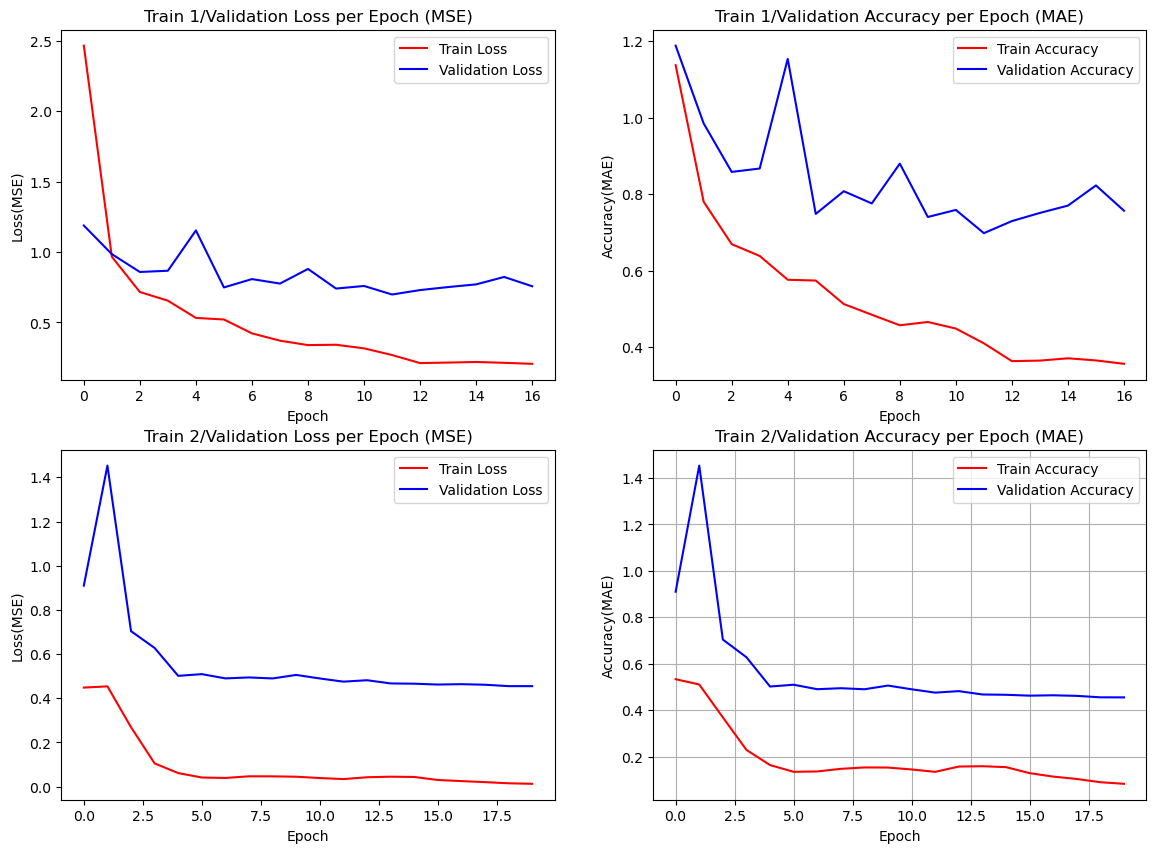

In [134]:
figure, ax = plt.subplots(nrows=2,ncols=2,figsize=(14,10))
plt.grid(True)

# Train1 - Plot for the training/validation loss per epoch

ax[0,0].plot(history1.history['loss'], label='Train Loss', c='red')
ax[0,0].plot(history1.history['val_loss'], label='Validation Loss', c='blue')
ax[0,0].set_xlabel('Epoch')
ax[0,0].set_ylabel('Loss(MSE)')
ax[0,0].legend()
ax[0,0].set_title('Train 1/Validation Loss per Epoch (MSE)')

# Train1 - Plot for the training/validation accuracy per epoch

ax[0,1].plot(history1.history['mean_absolute_error'], label='Train Accuracy',  c='red')
ax[0,1].plot(history1.history['val_loss'], label='Validation Accuracy', c='blue')
ax[0,1].set_xlabel('Epoch')
ax[0,1].set_ylabel('Accuracy(MAE)')
ax[0,1].legend()
ax[0,1].set_title('Train 1/Validation Accuracy per Epoch (MAE)')


# Train 2 - Plot for the training/validation loss per epoch

ax[1,0].plot(history2.history['loss'], label='Train Loss', c='red')
ax[1,0].plot(history2.history['val_loss'], label='Validation Loss', c='blue')
ax[1,0].set_xlabel('Epoch')
ax[1,0].set_ylabel('Loss(MSE)')
ax[1,0].legend()
ax[1,0].set_title('Train 2/Validation Loss per Epoch (MSE)')

# Train 2 - Plot for the training/validation accuracy per epoch

ax[1,1].plot(history2.history['mean_absolute_error'], label='Train Accuracy', c='red')
ax[1,1].plot(history2.history['val_loss'], label='Validation Accuracy', c='blue')
ax[1,1].set_xlabel('Epoch')
ax[1,1].set_ylabel('Accuracy(MAE)')
ax[1,1].legend()
ax[1,1].set_title('Train 2/Validation Accuracy per Epoch (MAE)')

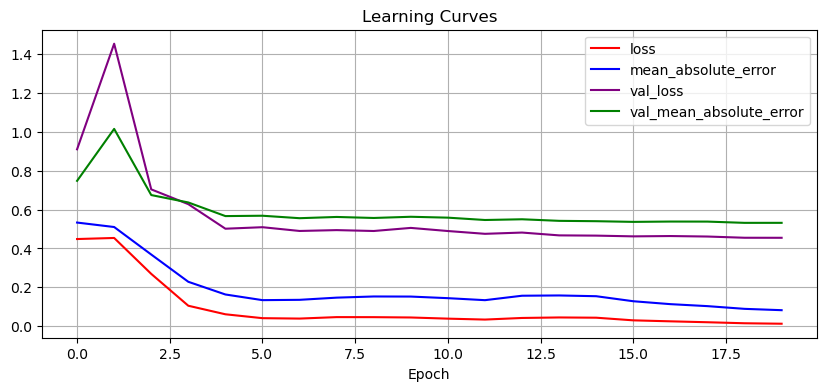

In [135]:
# Plot for the entire history

color_dict = {'loss': 'red', 'mean_absolute_error': 'blue', 
              'val_loss': 'purple', 'val_mean_absolute_error': 'green' }
pd.DataFrame(history2.history).plot(figsize=(10,4), color=color_dict)
plt.grid(True)
#plt.gca().set_ylim(0,1)
plt.xlabel("Epoch")
plt.title("Learning Curves")
plt.show()

In [172]:
model.save_weights("aesthetic_regressor/")

# 4. Test the Model

In [175]:
from tensorflow.keras.models import load_model

model_fin = load_model('aesthetic_regressor/')

In [176]:
# Evaluate the model on the test dataset

test_loss, test_mae = model_fin.evaluate(test_generator)
print(f' Test Loss: {test_loss} \n Test MAE: {test_mae}')

  34/1247 [..............................] - ETA: 3s - loss: 0.0000e+00 - mean_absolute_error: 0.0000e+00 

2023-04-15 17:54:13.112912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1247/1247 [==============================] - 4s 3ms/step - loss: 0.0000e+00 - mean_absolute_error: 0.0000e+00
 Test Loss: 0.0 
 Test MAE: 0.0


In [177]:
# Predict the scores for the test dataset
test_generator.reset()
y_pred = model_fin.predict(test_generator, verbose = 1)

# Print the predicted scores
print(y_pred)

2023-04-15 17:54:24.224575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1247/1247 [==============================] - 23s 18ms/step
[[4.941261 ]
 [4.8984404]
 [5.49994  ]
 ...
 [4.7188125]
 [5.2196383]
 [5.0913963]]


In [178]:
# True Score
y_true = []
test_filenames = test_generator.filenames

for filename in test_filenames:
    score = df_test[df_test["ImageID_JPG"] == filename]["Score"].values[0]  # extract the score for the image
    y_true.append(score)
y_true = np.array(y_true)

# Compare y_pred with y_score
mse = np.mean(np.square(y_pred - y_true))
mae = np.mean(np.abs(y_pred - y_true))

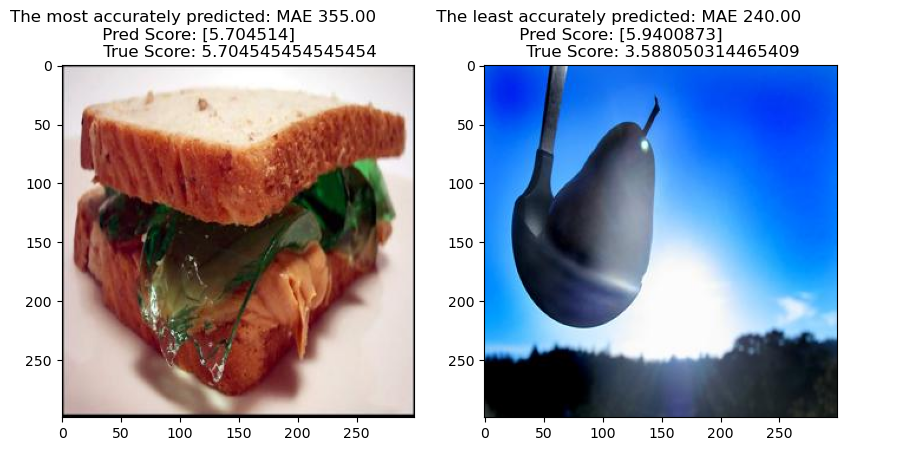

In [179]:
from tensorflow.keras.utils import load_img

# Predict 
#y_pred = model.predict(test_generator)

# True Score
y_true = []
test_filenames = test_generator.filenames

for filename in test_filenames:
    score = df_test[df_test["ImageID_JPG"] == filename]["Score"].values[0]  # extract the score for the image
    y_true.append(score)
y_true = np.array(y_true)

# Calculate error (MAE) and save the corresponding index
errors = abs(y_pred[:,0] - y_true)
max_error_index = np.argmax(errors)
min_error_index = np.argmin(errors)

# Find the filenames for the images
filenames = test_generator.filenames
max_error_filename = os.path.join(test_image_dir, filenames[max_error_index])
min_error_filename = os.path.join(test_image_dir, filenames[min_error_index])

# Call the images
max_error_image = load_img(max_error_filename)
min_error_image = load_img(min_error_filename)

# Display the images
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(min_error_image)
ax[0].set_title(f'The most accurately predicted: MAE {np.argmin(errors):.2f} \
                \n Pred Score: {y_pred[min_error_index]}\
                \n True Score: {y_true[min_error_index]}')
ax[1].imshow(max_error_image)
ax[1].set_title(f' The least accurately predicted: MAE {np.argmax(errors):.2f} \
                \n Pred Score: {y_pred[max_error_index]}\
                \n True Score: {y_true[max_error_index]}')
plt.show()

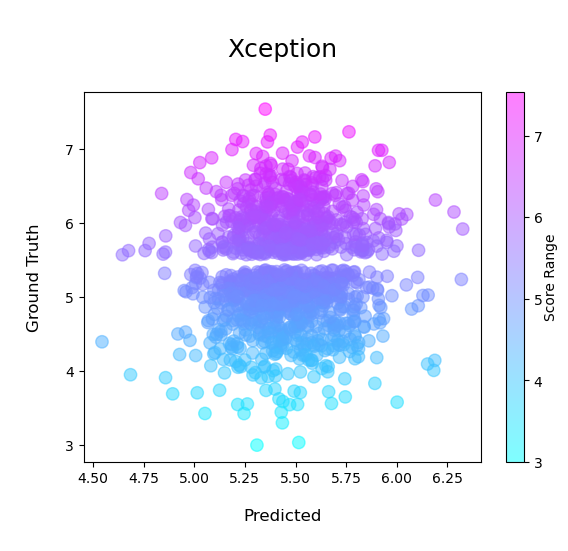

In [180]:
import matplotlib.pyplot as plt


N = y_test.shape
x = y_pred_mean
y = df_test["Score"]
colors = df_test["Score"]
area = 80

plt.title("\nXception\n", fontsize=18)
plt.xlabel("\nPredicted\n", fontsize=12)
plt.ylabel("\nGround Truth\n", fontsize=12)
marker_size=15

plt.scatter(x, y, s=area, c=colors, cmap='cool', alpha=0.5)

cbar = plt.colorbar()
cbar.set_label("Score Range", labelpad=+1)

plt.show()

In [181]:
# R2

from sklearn.metrics import r2_score

r2_score(y_true, y_pred)

0.24832226949819658

In [182]:
# MAE 
from sklearn.metrics import median_absolute_error

median_absolute_error(y_true, y_pred)

0.4222286072135528

In [183]:
# MSE 

from sklearn.metrics import mean_squared_error

mean_squared_error(y_true, y_pred)

0.4114975738306331

# 5. Save the model

In [184]:
model.save('ava_fooddrink_prediction.h5')

In [187]:
from tensorflow.keras.models import load_model

new_model = tf.keras.models.load_model('ava_fooddrink_prediction.h5')

### Model
1. Data Preprocessing (Single score): Image Input, resizing, 
2. Train / Test / Validation split
3. Train the model (freeze, add layer, unfreeze, re-train)
4. Validation
5. Test
6. Save the model

### Appliacation
1. Input image
2. Image resizing
3. Model application
4. Score display